In [2]:
from comp_overrule import learn_srules, learn_s_orules, get_overlap_violations
from comp_overrule_knn import learn_orules as learn_knnrules
from comp_overrule_clr import learn_orules as learn_clrrules

from comp_overrule import plt_cl_lit, plt_sem, get_sem_optim
from utils import rule_str, rules_stats, transcribe, recent_model, covbal_eval, description
from comp_preprocessing import get_data, select_data

from comp_causalmodel import causal_eval, bootstrap_effects, placebo_effects, bootstrap_marginal
from comp_causalmodel import propensity_model, outcome_model
from comp_postivitree import learn_rules

import numpy as np
import pandas as pd

from matplotlib_venn import venn2, venn3
%load_ext autoreload
%autoreload 2

### Preprocessing

In [1]:
folder = '/home/victora/PositivityViolation/'
varenc = 'data/varencoding-sl.txt'

In [3]:
data = select_data(data_path=folder + 'data/SL_2019_Preprocessed.csv')
data[['treatment', 'outcome']].groupby(['treatment']).mean()

23


,outcome
treatment,
0.0,0.104543
1.0,0.195385


In [ ]:
print([description(x, varenc) for x in pd.read_csv(DATA_PATH).columns[:-2]])

In [9]:
ENCODE = True
DATA_PATH = folder + 'data/fp_sl_select1622022777.csv'
X_df, a, y = get_data(data_path=DATA_PATH, encode=ENCODE)

In [5]:
X_df.shape

(4074, 63)

In [6]:
pd.concat((a,y), axis=1).groupby(['treatment']).mean()

,outcome
treatment,
0.0,0.104543
1.0,0.195385


### Causal models

100%|██████████| 1000/1000 [00:04<00:00, 246.83it/s]


(2.0433327244802912, 1.4029999311294532, 2.9682638570774165)

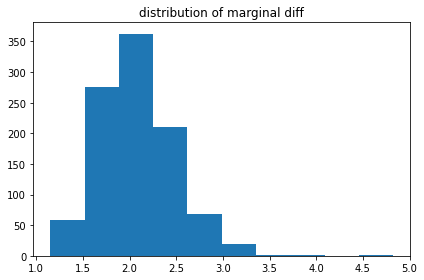

In [7]:
bootstrap_marginal(data_path=DATA_PATH, effect_type='or')

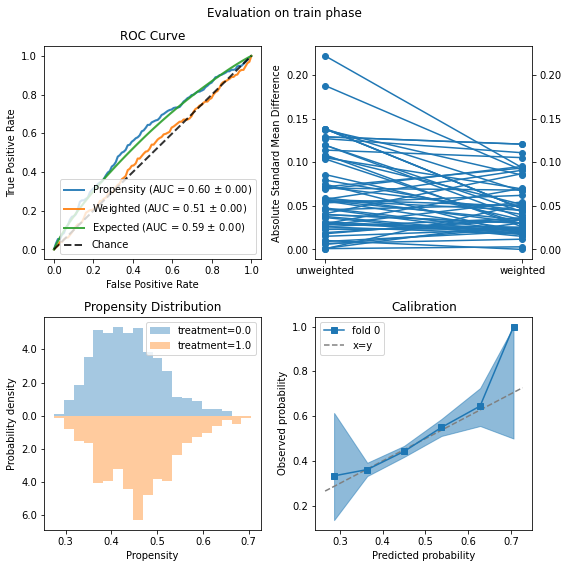

In [11]:
MODEL = 'ipw'
evaluations, X_test, a_test, y_test = propensity_model(data_path=DATA_PATH, encode=ENCODE, method='sigmoid', model=MODEL)

In [12]:
evaluations.scores.covariate_balance.sort_values(by='weighted')

abs_smd,weighted,unweighted
covariate,,
v501_4,0.000027,0.010280
v384c,0.003008,0.000951
v155_1,0.011787,0.006947
v513_4,0.014979,0.036566
v217_4,0.016905,0.046435
...,...,...
v102_1,0.120699,0.129129
v301,NaN,NaN
v155_4,NaN,NaN


In [54]:
description('v133',varenc)

'Education in single years '

In [13]:
covbal_eval(evaluations, 3)

array(['Type of place of residence', 'Wealth index combined'],
      dtype=object)

100%|██████████| 1000/1000 [00:20<00:00, 49.08it/s]


(1.6373143596947393, 1.117100818856911, 2.420039725759265)

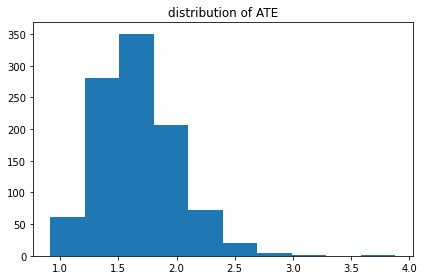

In [15]:
bootstrap_effects(evaluations.models, X_test, a_test, y_test, n_bootstrap=1000, effect_type='or')

In [16]:
bestmodel = evaluations.models.learner.steps[1][1].best_estimator_

100%|██████████| 1000/1000 [02:06<00:00,  7.93it/s]


(1.0118588669696313, 0.6817583315439817, 1.439696986798717)

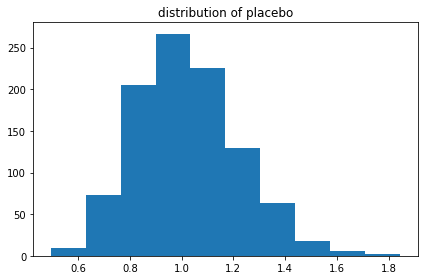

In [17]:
placebo_effects(bestmodel, X_test, a_test, y_test, n_bootstrap=1000, model=MODEL)

In [84]:
# evaluations, X_test, y_test, a_test = outcome_model(data_path=DATA_PATH, encode=True)
# evaluations.scores

### Overlap models

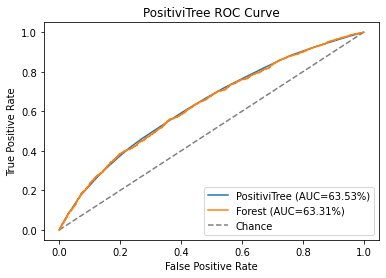

In [18]:
scores, voilating_index, transcript, leaves = learn_rules(data_path=DATA_PATH, var_encoding = folder+ varenc, relative=False)

In [19]:
1 - len(voilating_index)/len(X_df)

1.0

In [20]:
transcript

[]

In [169]:
ptree_vindex = voilating_index
knn_vindex = []
clr_vindex = []
support_vindex = []

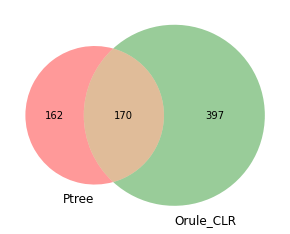

In [170]:
set1 = set(ptree_vindex)
set2 = set(knn_vindex)
set3 = set(clr_vindex)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
venn2([set1, set3], ('Ptree', 'Orule_CLR'), ax=ax)

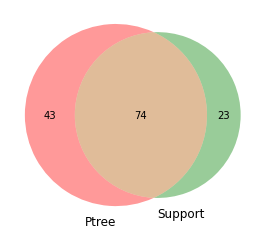

In [33]:
set1 = set(ptree_vindex)
set2 = set(support_vindex)
fig, ax = plt.subplots()
venn2([set1, set2], ('Ptree', 'Support'), ax=ax)

In [33]:
import time
timestamp = str(int(time.time()))
fig.savefig(folder + 'figures/venn3' + timestamp + '.pdf')

In [34]:
overlap_Xdf = X_df.loc[~X_df.index.isin(clr_vindex)]
overlap_adf = a.loc[~X_df.index.isin(clr_vindex)]
overlap_ydf = y.loc[~X_df.index.isin(clr_vindex)]

concat_df = pd.concat((overlap_Xdf, overlap_adf, overlap_ydf), axis=1)

In [35]:
concat_df.to_csv(folder + '/data/fp_select_overlap_clr-et-2.csv', index=False)

In [104]:
import matplotlib.pyplot as plt

In [148]:
o_test_props.values

array([0.61352711, 0.61021695, 0.61114996, ..., 0.6084929 , 0.61149588,
       0.61430583])

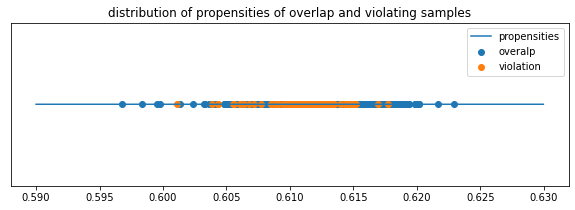

In [168]:
y = [1] * len(o_test_props)
plt.plot(np.arange(0.59, 0.63, 0.040000000000000036/len(o_test_props)), y)
plt.scatter(o_test_props.values, y)

y = [1] * len(v_test_props)
plt.scatter(v_test_props.values, y)


plt.rcParams["figure.figsize"] = (10,3)
plt.yticks([])
plt.legend(['propensities', 'overalp', 'violation'])
plt.title('distribution of propensities of overlap and violating samples')
plt.show()

In [161]:
0.63 - 0.59

0.040000000000000036

In [139]:
v_test = set(voilating_index).intersection(set(a_test.index))
o_test = set(set(a_test.index).difference(voilating_index))

In [ ]:
props = evaluations.models.compute_propensity(X_test, a_test)

o_test_props = props[o_test]
v_test_props = props[v_test]

In [146]:
o_test_props

1       0.613527
4098    0.610217
8       0.611150
4106    0.614256
12      0.611837
          ...   
4080    0.611768
4081    0.611735
4086    0.608493
4087    0.611496
4095    0.614306
Name: 1, Length: 1211, dtype: float64